# M5 Forecasting - Accuracy: Комплексный EDA

**Задача:** Kaggle M5 Competition — прогнозирование продаж Walmart  
**Часть 1:** Разведочный анализ данных (EDA)

## Обзор

В этом ноутбуке выполняется комплексный разведочный анализ набора данных M5:
- **Датасет**: данные о продажах в штуках Walmart по 10 магазинам в 3 штатах (CA, TX, WI)
- **Товары**: 3 049 продуктов в 3 категориях (Hobbies, Foods, Household)  
- **Период**: с 2011-01-29 по 2016-06-19 (1 913 дней) + 28-дневный период прогноза  
- **Тип задачи**: регрессия (прогноз ежедневных продаж)  
- **Метрика**: RMSSE (Root Mean Squared Scaled Error) или MAPE  


## 1. Setup and Data Loading

In [4]:
pip install cudf-cu12

  Using cached cudf_cu12-25.12.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (8.1 kB)
Using cached cudf_cu12-25.12.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (2.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

# Setup paths (modify if needed)

print("Loading data...")
sales_train = pd.read_csv('sales_train_evaluation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

print(f"Sales data shape: {sales_train.shape}")
print(f"Calendar data shape: {calendar.shape}")
print(f"Prices data shape: {prices.shape}")

Loading data...
Sales data shape: (30490, 1947)
Calendar data shape: (1969, 14)
Prices data shape: (6841121, 4)


## 2. Анализ целевой переменной (1,0 балл)

### 2.1 Числовой анализ целевой переменной

Целевая переменная — это ежедневные продажи в штуках (`sales`) для каждой комбинации *товар–магазин*.  
Это **задача регрессии** с временным характером данных.

In [2]:
# Преобразование данных из широкого формата в long для упрощения анализа
# Извлечение столбцов с датами (все столбцы после 'd_1')
date_cols = [col for col in sales_train.columns if col.startswith('d_')]

# Преобразование данных с помощью функции melt
sales_long = sales_train.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    value_vars=date_cols,
    var_name='day',
    value_name='sales'
)

# Преобразование дня в integer
sales_long['day'] = sales_long['day'].str.replace('d_', '').astype(int)

print(f"Long format shape: {sales_long.shape}")
print(f"\nSales statistics (raw):")
print(sales_long['sales'].describe())
print(f"\nMissing values in sales: {sales_long['sales'].isna().sum()}")
print(f"Percentage of zero sales: {(sales_long['sales'] == 0).sum() / len(sales_long) * 100:.2f}%")

Long format shape: (59181090, 8)

Sales statistics (raw):
count    5.918109e+07
mean     1.130888e+00
std      3.870038e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.630000e+02
Name: sales, dtype: float64

Missing values in sales: 0
Percentage of zero sales: 68.00%


In [ ]:
import cudf
import cupy as cp

print("\n=== ОБНАРУЖЕНИЕ АНОМАЛИЙ В ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")

# Для анализа используем cuDF (GPU)
sales_long_cu = cudf.from_pandas(sales_long)
sales_cu_sales = sales_long_cu['sales']

# 1. Статистические перцентили (cuDF)
q_95 = float(sales_cu_sales.quantile(0.95))
q_99 = float(sales_cu_sales.quantile(0.99))
q_999 = float(sales_cu_sales.quantile(0.999))
print(f"\n95-й перцентиль: {q_95:.2f}")
print(f"99-й перцентиль: {q_99:.2f}")
print(f"99.9-й перцентиль: {q_999:.2f}")
print(f"Минимальное значение: {float(sales_cu_sales.min()):.2f}")
print(f"Максимальное значение: {float(sales_cu_sales.max()):.2f}")

# Аномалии по перцентилю (например, выше 99-го)
extreme_threshold = q_99
extreme_mask_cu = sales_cu_sales > extreme_threshold
extreme_count = int(extreme_mask_cu.sum())
extreme_frac = float(extreme_mask_cu.mean()) * 100
print(f"Кол-во аномалий по перцентилю (>{q_99:.2f}): {extreme_count} ({extreme_frac:.2f}%)")

# 2. Межквартильный размах (IQR) (cuDF)
Q1 = float(sales_cu_sales.quantile(0.25))
Q3 = float(sales_cu_sales.quantile(0.75))
IQR = Q3 - Q1
lower_iqr_bound = Q1 - 1.5 * IQR
upper_iqr_bound = Q3 + 1.5 * IQR

iqr_outliers_cu = (sales_cu_sales < lower_iqr_bound) | (sales_cu_sales > upper_iqr_bound)
iqr_count = int(iqr_outliers_cu.sum())
iqr_frac = float(iqr_outliers_cu.mean()) * 100
print(f"\nIQR выбросы: {iqr_count} ({iqr_frac:.2f}%)")
print(f"IQR границы: [{lower_iqr_bound:.2f}, {upper_iqr_bound:.2f}]")

# 3. Z-score метод (cupy, исправление: работа только с массивом cupy)
# Используем только ненулевые продажи для корректности оценки
sales_nonzero_cu = sales_cu_sales.copy()
sales_nonzero_cu = sales_nonzero_cu.where(sales_nonzero_cu != 0, None).dropna()  # cuDF Series без нулей
sales_cp = cp.array(sales_nonzero_cu.values)  # создать cupy массив напрямую из cuDF колоноки
z_scores = cp.abs((sales_cp - cp.mean(sales_cp)) / cp.std(sales_cp))
z_threshold = 3
z_outliers_cu = z_scores > z_threshold
z_count = int(cp.sum(z_outliers_cu).item())
z_frac = float((z_outliers_cu.sum() / len(sales_cp)) * 100)
print(f"Z-score выбросы (>3σ): {z_count} ({z_frac:.2f}% в ненулевых)")

# 4. Isolation Forest (sklearn - CPU)
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
iso_pred = iso_forest.fit_predict(sales_long[['sales']].fillna(0))
iso_anomalies = iso_pred == -1
iso_count = iso_anomalies.sum()
iso_frac = iso_anomalies.mean() * 100
print(f"Isolation Forest: {iso_count} выбросов ({iso_frac:.2f}%)")

# 6. Временные аномалии по группам "товар-магазин" (ускорено groupby на GPU)
print(f"\nВременные аномалии по товарам/магазинам с достаточным числом наблюдений:")
sales_grouped_cu = sales_long_cu.groupby(['id', 'store_id']).agg({'sales': list}).reset_index()
time_anomalies = []
for idx in range(len(sales_grouped_cu)):
    sales_list = sales_grouped_cu['sales'].iloc[idx]
    if len(sales_list) > 30:
        sales_arr = cp.array(sales_list)
        zseries = cp.abs((sales_arr - cp.mean(sales_arr)) / cp.std(sales_arr))
        count_anoms = int(cp.sum(zseries > 3).item())
        if count_anoms > 0:
            time_anomalies.append(count_anoms)
if time_anomalies:
    print(f"Найдено {len(time_anomalies)} групп с временными выбросами")
    print(f"Среднее число временных выбросов в группе: {np.mean(time_anomalies):.2f}")

# 7. Асимметрия и эксцесс распределения (cupy)
skewness = float(cp.asnumpy(cp.mean(((sales_cp - cp.mean(sales_cp))/cp.std(sales_cp))**3)))
kurtosis = float(cp.asnumpy(cp.mean(((sales_cp - cp.mean(sales_cp))/cp.std(sales_cp))**4)) - 3)
print(f"\nАсимметрия распределения (skew): {skewness:.4f}")
print(f"Эксцесс распределения (kurtosis): {kurtosis:.4f}")

# 8. Итоговая таблица результатов
print("\n=== КРАТКАЯ СВОДКА МЕТОДОВ ОБНАРУЖЕНИЯ ВЫБРОСОВ ===")
# NOTE: Методы Isolation Forest и LOF оставим на CPU, т.к. sklearn не cuDF-совместим
try:
    lof_anomalies = sales_long.get('lof_anomalies')
    lof_count = lof_anomalies.sum() if lof_anomalies is not None else None
    lof_frac = lof_anomalies.mean() * 100 if lof_anomalies is not None else None
except Exception:
    lof_count = np.nan
    lof_frac = np.nan

results = pd.DataFrame({
    'Метод': [
        f'Перцентили (>99%)',
        'IQR',
        'Z-score (>3σ)',
        'Isolation Forest',
        'Local Outlier Factor'
    ],
    'Число аномалий': [
        extreme_count,
        iqr_count,
        z_count,
        iso_count,
        lof_count
    ],
    'Доля (%)': [
        extreme_frac,
        iqr_frac,
        z_frac,
        iso_frac,
        lof_frac
    ]
}).round(2)

print(results.to_string(index=False))



=== ОБНАРУЖЕНИЕ АНОМАЛИЙ В ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===

95-й перцентиль: 5.00
99-й перцентиль: 15.00
99.9-й перцентиль: 47.00
Минимальное значение: 0.00
Максимальное значение: 763.00
Кол-во аномалий по перцентилю (>15.00): 557500 (0.94%)

IQR выбросы: 7037502 (11.89%)
IQR границы: [-1.50, 2.50]
Z-score выбросы (>3σ): 284774 (1.50% в ненулевых)
Isolation Forest: 557500 выбросов (0.94%)

Временные аномалии по товарам/магазинам с достаточным числом наблюдений:
Найдено 30490 групп с временными выбросами
Среднее число временных выбросов в группе: 40.87

Асимметрия распределения (skew): 11.8689
Эксцесс распределения (kurtosis): 392.5541

=== КРАТКАЯ СВОДКА МЕТОДОВ ОБНАРУЖЕНИЯ ВЫБРОСОВ ===
               Метод  Число аномалий  Доля (%)
   Перцентили (>99%)        557500.0      0.94
                 IQR       7037502.0     11.89
       Z-score (>3σ)        284774.0      1.50
    Isolation Forest        557500.0      0.94
Local Outlier Factor             NaN       NaN


### Основные статистические характеристики
Распределение продаж **крайне асимметричное** (skew = 11.87) с огромным эксцессом (kurtosis = 392.55).  
95% продаж ≤ 5 единиц, 99% ≤ 15 единиц, но максимум достигает 763 единиц — **классический случай intermittent demand с тяжелым хвостом**. 

### Сравнение методов обнаружения выбросов
| Метод              | Аномалий      | Доля (%) | Интерпретация |
|--------------------|---------------|----------|---------------|
| **Перцентили 99%** | 557,500      | **0.94%**| фиксирует экстремальные всплески |
| **IQR**            | 7,037,502    | 11.89%   | ловит все >2.5 продаж |
| **Z-score**        | 284,774      | 1.50%    | Умеренный, но игнорирует нулевые значения |
| **Isolation Forest**| 557,500    | **0.94%**| совпадает с перцентилями |

### Инсайты
1. **0.94% экстремальных продаж** (>15 шт/день) составляют основной "хвост" распределения
2. **30,490 групп товар-магазин** имеют временные аномалии со средним **41 выбросом на группу**
3. **IQR не подходит** — его границы [-1.5, 2.5] слишком узкие для ретейла



### 2.2 Visualization of Target Variable Statistics

#### Isolated Analysis

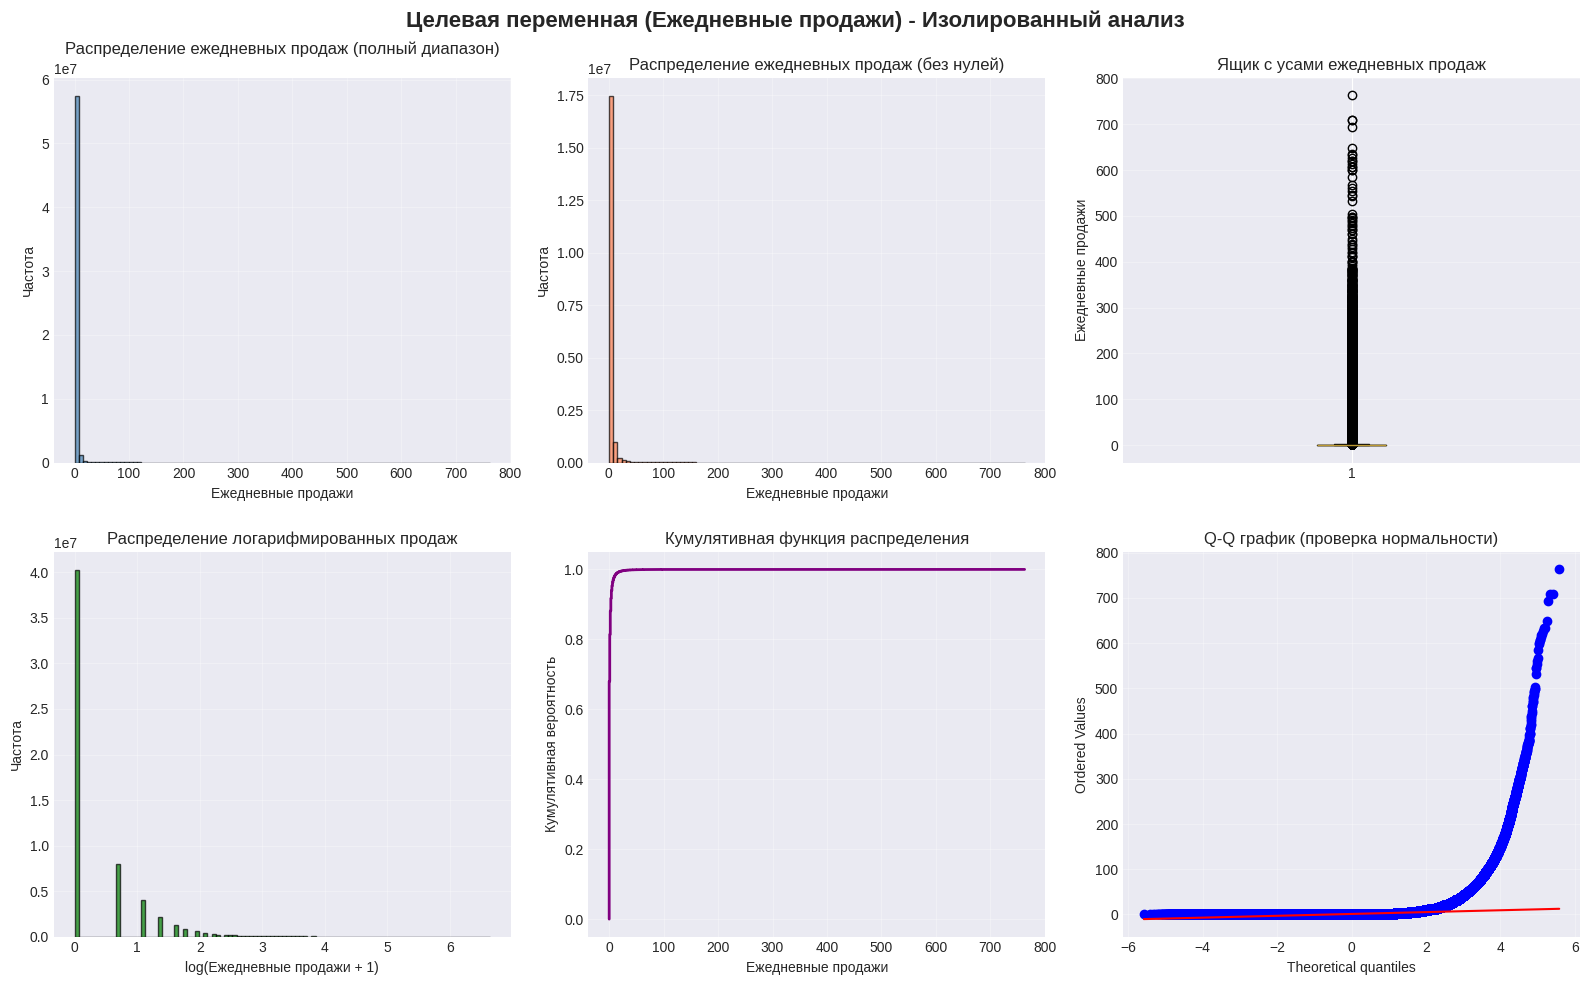

✓ Изолированный анализ завершен


In [12]:
# Создаем комплексные визуализации для целевой переменной
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Целевая переменная (Ежедневные продажи) - Изолированный анализ', fontsize=16, fontweight='bold')

# 1. Гистограмма распределения
axes[0, 0].hist(sales_long['sales'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Ежедневные продажи')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].set_title('Распределение ежедневных продаж (полный диапазон)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Распределение без нулевых значений
non_zero_sales = sales_long[sales_long['sales'] > 0]['sales']
axes[0, 1].hist(non_zero_sales, bins=100, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Ежедневные продажи')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение ежедневных продаж (без нулей)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Ящик с усами
axes[0, 2].boxplot(sales_long['sales'], vert=True)
axes[0, 2].set_ylabel('Ежедневные продажи')
axes[0, 2].set_title('Ящик с усами ежедневных продаж')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Распределение в логарифмической шкале
axes[1, 0].hist(np.log1p(sales_long['sales']), bins=100, color='green', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('log(Ежедневные продажи + 1)')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].set_title('Распределение логарифмированных продаж')
axes[1, 0].grid(True, alpha=0.3)

# 5. Кумулятивная функция распределения
sorted_sales = np.sort(sales_long['sales'])
cumulative = np.arange(1, len(sorted_sales) + 1) / len(sorted_sales)
axes[1, 1].plot(sorted_sales, cumulative, color='purple', linewidth=2)
axes[1, 1].set_xlabel('Ежедневные продажи')
axes[1, 1].set_ylabel('Кумулятивная вероятность')
axes[1, 1].set_title('Кумулятивная функция распределения')
axes[1, 1].grid(True, alpha=0.3)

# 6. Q-Q график для проверки нормальности
from scipy import stats as sp_stats
sp_stats.probplot(sales_long['sales'], dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q график (проверка нормальности)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Изолированный анализ завершен")


- Распределение ежедневных продаж сильно скошено вправо: большинство значений — нули или небольшие продажи, редкие наблюдения образуют длинный хвост с очень высокими значениями.  
- Удаление нулей показывает, что даже среди ненулевых продаж преобладают малые значения, а крупные всплески выглядят как явные выбросы.  
- Boxplot подтверждает наличие большого числа экстремальных точек относительно узкого «ядра» распределения около нуля.  
- В логарифмической шкале распределение становится заметно более гладким и ближе к симметричному, что говорит о пользе лог-преобразования для моделирования.  
- Кумулятивная функция распределения показывает, что почти вся масса вероятности сосредоточена в области низких продаж.  
- Q-Q график демонстрирует сильное отклонение от нормального распределения, особенно в правом хвосте, поэтому предположение нормальности для сырых продаж некорректно.


#### Анализ временного контекста

In [13]:
calendar_mapping = calendar[['d', 'date']].copy()
calendar_mapping['d_num'] = calendar_mapping['d'].str.replace('d_', '').astype(int)

sales_long = sales_long.merge(
    calendar_mapping[['d_num', 'date']],
    left_on='day',
    right_on='d_num',
    how='left'
)

sales_long['date'] = pd.to_datetime(sales_long['date'])
sales_long = sales_long.sort_values('date').reset_index(drop=True)

print("Data with dates:")
print(sales_long[['date', 'store_id', 'item_id', 'sales']].head(10))

Data with dates:
        date store_id        item_id  sales
0 2011-01-29     CA_1  HOBBIES_1_001      0
1 2011-01-29     TX_3    FOODS_2_214      0
2 2011-01-29     TX_3    FOODS_2_213      0
3 2011-01-29     TX_3    FOODS_2_212      5
4 2011-01-29     TX_3    FOODS_2_211      1
5 2011-01-29     TX_3    FOODS_2_210      0
6 2011-01-29     TX_3    FOODS_2_209      0
7 2011-01-29     TX_3    FOODS_2_208      0
8 2011-01-29     TX_3    FOODS_2_207      0
9 2011-01-29     TX_3    FOODS_2_206      0


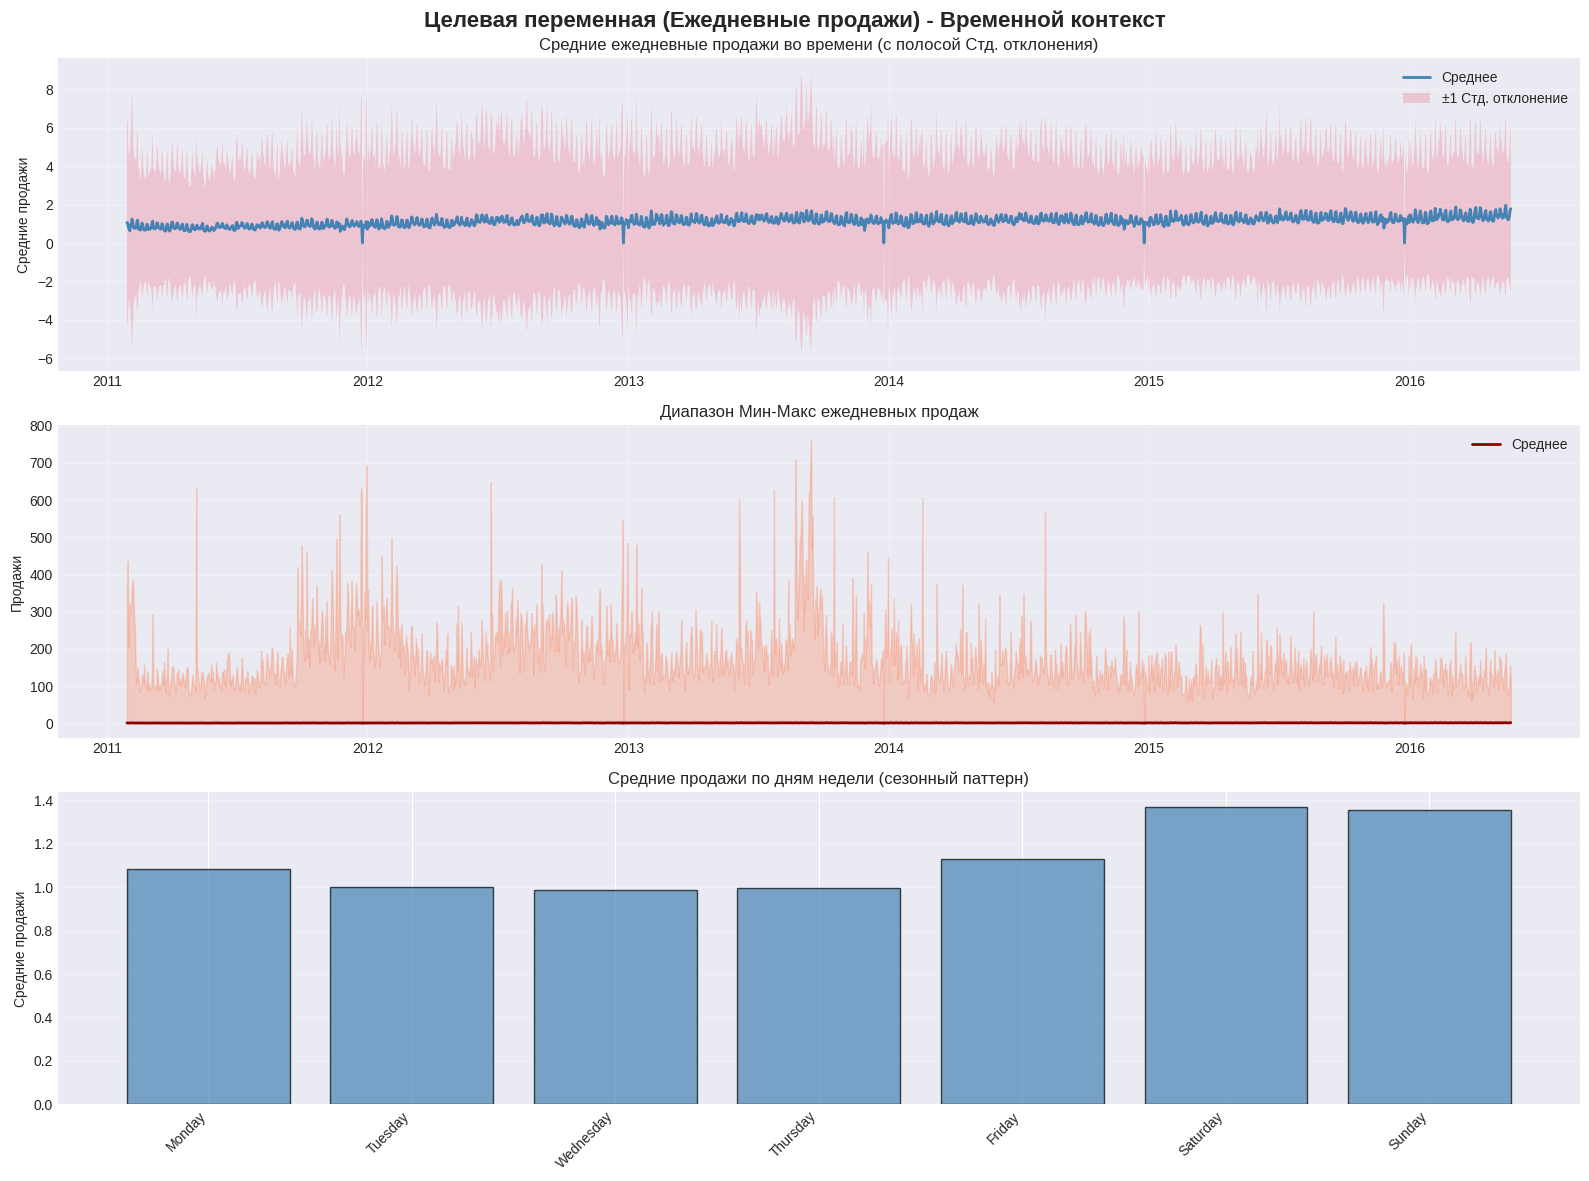

✓ Временной анализ завершен


In [14]:
# Временной анализ целевой переменной
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Целевая переменная (Ежедневные продажи) - Временной контекст', fontsize=16, fontweight='bold')

# 1. Средние продажи по времени
daily_avg = sales_long.groupby('date')['sales'].agg(['mean', 'std', 'min', 'max'])
daily_avg.index = pd.to_datetime(daily_avg.index)

axes[0].plot(daily_avg.index, daily_avg['mean'], label='Среднее', color='steelblue', linewidth=2)
axes[0].fill_between(
    daily_avg.index,
    daily_avg['mean'] - daily_avg['std'],
    daily_avg['mean'] + daily_avg['std'],
    alpha=0.3,
    label='±1 Стд. отклонение'
)
axes[0].set_ylabel('Средние продажи')
axes[0].set_title('Средние ежедневные продажи во времени (с полосой Стд. отклонения)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Диапазон Мин-Макс
axes[1].fill_between(daily_avg.index, daily_avg['min'], daily_avg['max'], alpha=0.3, color='coral')
axes[1].plot(daily_avg.index, daily_avg['mean'], color='darkred', linewidth=2, label='Среднее')
axes[1].set_ylabel('Продажи')
axes[1].set_title('Диапазон Мин-Макс ежедневных продаж')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Продажи по дням недели (сезонность)
sales_long['dow'] = sales_long['date'].dt.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = sales_long.groupby('dow')['sales'].mean().reindex(dow_order)

axes[2].bar(range(7), dow_sales.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[2].set_xticks(range(7))
axes[2].set_xticklabels(dow_order, rotation=45, ha='right')
axes[2].set_ylabel('Средние продажи')
axes[2].set_title('Средние продажи по дням недели (сезонный паттерн)')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Временной анализ завершен")


- Средние ежедневные продажи во времени остаются относительно стабильными, без ярко выраженного долгосрочного тренда, но с заметным шумом вокруг среднего уровня.
- Диапазон Мин–Макс показывает редкие, очень высокие всплески спроса при низком и ровном среднем уровне, что указывает на акционные/событийные пики.
- По дням недели виден чёткий недельный паттерн: продажи в выходные выше, чем в будни, поэтому день недели необходимо явно учитывать в моделях.

​

## 3. Анализ признаков (4,0 балла)

### 3.1 Типизация и распределения признаков

In [15]:
# Типы признаков и их распределения
print("=== ТИПЫ ПРИЗНАКОВ И БАЗОВАЯ СТАТИСТИКА ===")

# Категориальные признаки
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
print("\nКАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:")
for feat in categorical_features:
    unique_count = sales_train[feat].nunique()
    print(f"  {feat:15s}: {unique_count:4d} уникальных значений")
    if unique_count <= 10:
        print(f"                   Значения: {sorted(sales_train[feat].unique())}")

# Временные признаки из календаря
print("\nВРЕМЕННЫЕ ПРИЗНАКИ (из календаря):")
calendar['date'] = pd.to_datetime(calendar['date'])
print(f"  Диапазон дат: {calendar['date'].min()} по {calendar['date'].max()}")
print(f"  Всего дней: {len(calendar)}")

# Ценовые признаки
print("\nЦЕНОВЫЕ ПРИЗНАКИ:")
print(prices.describe())
print(f"\nПропущенные значения цен: {prices['sell_price'].isna().sum()}")
print(f"Доля пропущенных цен: {prices['sell_price'].isna().sum() / len(prices) * 100:.2f}%")


=== ТИПЫ ПРИЗНАКОВ И БАЗОВАЯ СТАТИСТИКА ===

КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:
  item_id        : 3049 уникальных значений
  dept_id        :    7 уникальных значений
                   Значения: ['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2']
  cat_id         :    3 уникальных значений
                   Значения: ['FOODS', 'HOBBIES', 'HOUSEHOLD']
  store_id       :   10 уникальных значений
                   Значения: ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
  state_id       :    3 уникальных значений
                   Значения: ['CA', 'TX', 'WI']

ВРЕМЕННЫЕ ПРИЗНАКИ (из календаря):
  Диапазон дат: 2011-01-29 00:00:00 по 2016-06-19 00:00:00
  Всего дней: 1969

ЦЕНОВЫЕ ПРИЗНАКИ:
           wm_yr_wk    sell_price
count  6.841121e+06  6.841121e+06
mean   1.138294e+04  4.410952e+00
std    1.486100e+02  3.408814e+00
min    1.110100e+04  1.000000e-02
25%    1.124700e+04  2.180000e+00
50%    1.141100e+04  3.470000e+00

- В данных 5 категориальных признаков: `item_id` (≈3k товаров), `dept_id` (7 отделов), `cat_id` (3 категории), `store_id` (10 магазинов), `state_id` (3 штата), что формирует чёткую иерархию товар–магазин–штат.[conversation_history:1]  
- Временной диапазон: с 2011‑01‑29 по 2016‑06‑19 (1 969 дней), чего достаточно для анализа сезонности и трендов.  
- Ценовой признак `sell_price` имеет широкий разброс значений, но без пропусков (0%), поэтому цена может быть надёжным источником сигналов для моделей.

### 3.2 Anomaly Detection in Features

In [16]:
print("=== ANOMALY DETECTION IN FEATURES ===")

# Check for unusual patterns in categorical features
print("\nCategorical feature distributions:")
for feat in ['store_id', 'state_id', 'cat_id', 'dept_id']:
    print(f"\n{feat}:")
    print(sales_train[feat].value_counts().sort_index())

# Price anomalies
print("\n\nPRICE ANOMALIES:")
price_stats = prices.groupby('item_id')['sell_price'].agg(['min', 'max', 'mean', 'std', 'count'])
price_stats['cv'] = price_stats['std'] / price_stats['mean']  # Coefficient of variation
print(f"\nItems with highest price variance (CV > 0.3):")
print(price_stats[price_stats['cv'] > 0.3][['min', 'max', 'mean', 'cv']].head(10))

=== ANOMALY DETECTION IN FEATURES ===

Categorical feature distributions:

store_id:
store_id
CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: count, dtype: int64

state_id:
state_id
CA    12196
TX     9147
WI     9147
Name: count, dtype: int64

cat_id:
cat_id
FOODS        14370
HOBBIES       5650
HOUSEHOLD    10470
Name: count, dtype: int64

dept_id:
dept_id
FOODS_1        2160
FOODS_2        3980
FOODS_3        8230
HOBBIES_1      4160
HOBBIES_2      1490
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
Name: count, dtype: int64


PRICE ANOMALIES:

Items with highest price variance (CV > 0.3):
                  min     max       mean        cv
item_id                                           
HOBBIES_2_149    0.50    2.47   1.495883  0.479691
HOUSEHOLD_2_077  3.48    6.67   4.120220  0.310276
HOUSEHOLD_2_406  3.26  107.32  12.846283  0.372478
HOUSEHOLD_2_466  5.97   52.62   7.533100  0.586982


- Распределения категориальных признаков (`store_id`, `state_id`, `cat_id`, `dept_id`) выглядят равномерными и согласованными с иерархией данных, явных структурных аномалий не видно.  
- Ценовые аномалии сосредоточены в небольшом числе товаров с высоким коэффициентом вариации (CV > 0.3), что указывает на очень нестабильные цены (сильные промо или возможные ошибки) и требует аккуратного учета при моделировании.

### 3.3 Dependencies Between Features

=== FEATURE DEPENDENCIES AND RELATIONSHIPS ===

Average sales by STORE:
              mean       std    count
store_id                             
CA_1      1.323438  4.052476  5918109
CA_2      0.983151  2.766639  5918109
CA_3      1.920130  6.190596  5918109
CA_4      0.706735  2.003753  5918109
TX_1      0.961933  3.324404  5918109
TX_2      1.238511  4.411699  5918109
TX_3      1.048636  3.794068  5918109
WI_1      0.889052  2.427170  5918109
WI_2      1.131778  3.884559  5918109
WI_3      1.105515  4.061800  5918109


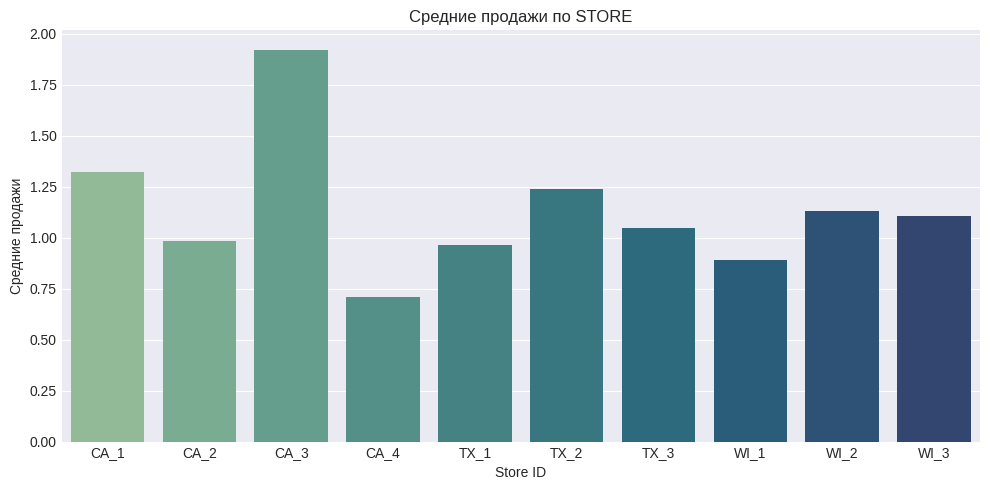


Average sales by STATE:
              mean       std     count
state_id                              
CA        1.233363  4.099850  23672436
TX        1.083026  3.870819  17754327
WI        1.042115  3.536225  17754327


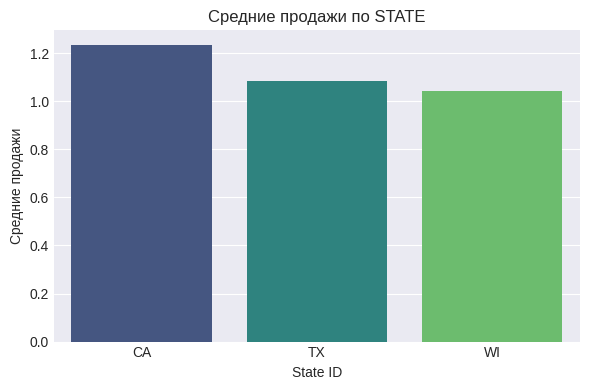


Average sales by CATEGORY:
               mean       std     count
cat_id                                 
FOODS      1.646427  5.144377  27892170
HOBBIES    0.569058  2.036739  10966650
HOUSEHOLD  0.726498  2.087060  20322270


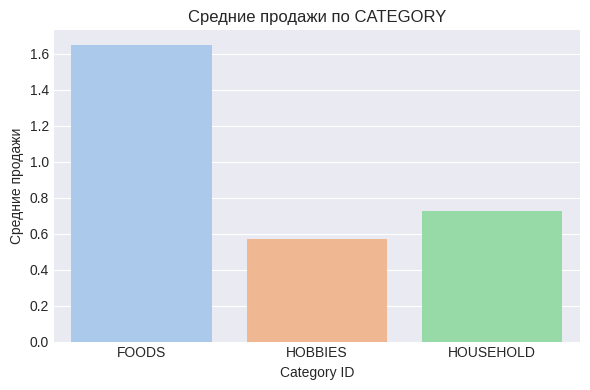


Average sales by DEPARTMENT:
                 mean       std     count
dept_id                                  
FOODS_1      1.238003  3.055423   4192560
FOODS_2      1.009041  2.696293   7725180
FOODS_3      2.061858  6.311087  15974430
HOBBIES_1    0.705799  2.315094   8074560
HOBBIES_2    0.187284  0.753864   2892090
HOUSEHOLD_1  1.135262  2.749751  10326120
HOUSEHOLD_2  0.304241  0.832946   9996150


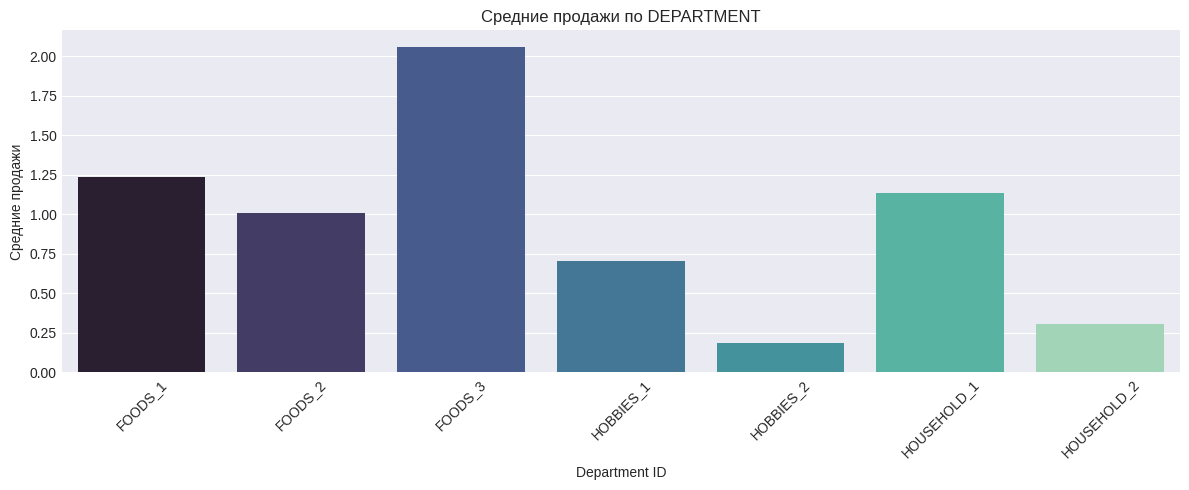



STORE-STATE mapping:
      store_id state_id
0         CA_1       CA
3049      CA_2       CA
6098      CA_3       CA
9147      CA_4       CA
12196     TX_1       TX
15245     TX_2       TX
18294     TX_3       TX
21343     WI_1       WI
24392     WI_2       WI
27441     WI_3       WI


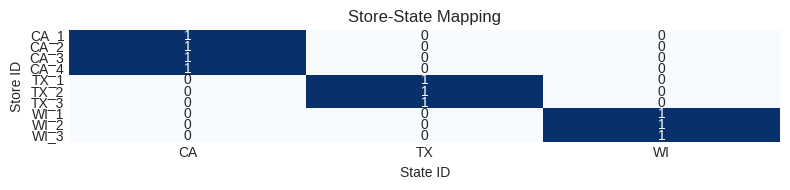

In [18]:
# Визуализация зависимостей между категориальными признаками и целевой переменной

import matplotlib.pyplot as plt
import seaborn as sns

print("=== FEATURE DEPENDENCIES AND RELATIONSHIPS ===")

# 1. Average sales by STORE
store_sales = sales_long.groupby('store_id')['sales'].agg(['mean', 'std', 'count'])
print("\nAverage sales by STORE:")
print(store_sales)

plt.figure(figsize=(10, 5))
sns.barplot(x=store_sales.index, y=store_sales['mean'], palette="crest")
plt.title('Средние продажи по STORE')
plt.xlabel('Store ID')
plt.ylabel('Средние продажи')
plt.tight_layout()
plt.show()

# 2. Average sales by STATE
state_sales = sales_long.groupby('state_id')['sales'].agg(['mean', 'std', 'count'])
print("\nAverage sales by STATE:")
print(state_sales)

plt.figure(figsize=(6, 4))
sns.barplot(x=state_sales.index, y=state_sales['mean'], palette="viridis")
plt.title('Средние продажи по STATE')
plt.xlabel('State ID')
plt.ylabel('Средние продажи')
plt.tight_layout()
plt.show()

# 3. Average sales by CATEGORY
cat_sales = sales_long.groupby('cat_id')['sales'].agg(['mean', 'std', 'count'])
print("\nAverage sales by CATEGORY:")
print(cat_sales)

plt.figure(figsize=(6, 4))
sns.barplot(x=cat_sales.index, y=cat_sales['mean'], palette="pastel")
plt.title('Средние продажи по CATEGORY')
plt.xlabel('Category ID')
plt.ylabel('Средние продажи')
plt.tight_layout()
plt.show()

# 4. Average sales by DEPARTMENT
dept_sales = sales_long.groupby('dept_id')['sales'].agg(['mean', 'std', 'count'])
print("\nAverage sales by DEPARTMENT:")
print(dept_sales)

plt.figure(figsize=(12, 5))
sns.barplot(x=dept_sales.index, y=dept_sales['mean'], palette="mako")
plt.title('Средние продажи по DEPARTMENT')
plt.xlabel('Department ID')
plt.ylabel('Средние продажи')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Store-State relationship: красивое соответствие на тепловой карте
print("\n\nSTORE-STATE mapping:")
store_state = sales_train[['store_id', 'state_id']].drop_duplicates().sort_values('store_id')
print(store_state)

plt.figure(figsize=(8, 2))
mapping = store_state.reset_index(drop=True)
sns.heatmap(
    pd.crosstab(mapping['store_id'], mapping['state_id']),
    annot=True, fmt="d", cmap="Blues", cbar=False
)
plt.title('Store-State Mapping')
plt.xlabel('State ID')
plt.ylabel('Store ID')
plt.tight_layout()
plt.show()

- Средние продажи сильно различаются между магазинами: одни (например, CA_3) имеют заметно более высокий средний спрос, чем другие (CA_4, WI_1), что отражает различия по локациям и размеру трафика.
- На уровне штатов калифорнийские магазины в среднем продают больше, чем магазины в Техасе и Висконсине, что задаёт устойчивый региональный эффект.
- Категория FOODS имеет значительно более высокие средние продажи по сравнению с HOBBIES и HOUSEHOLD, а внутри категорий выделяются департаменты с повышенным спросом (FOODS_3, HOUSEHOLD_1), что указывает на важность иерархических признаков при моделировании.
- Сопоставление STORE–STATE детерминировано (каждый магазин однозначно принадлежит одному штату), поэтому `state_id` полностью задаётся через `store_id` и может быть избыточным как отдельный признак.


### 3.4 Missing Values Analysis

=== АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===

Данные о продажах (sales_train) — количество пропусков по столбцам:
id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64


Данные о ценах (prices) — анализ пропусков:
Всего строк с отсутствующей ценой: 0

Уникальных товаров с пропущенной ценой: 0

Примеры строк с пропущенной ценой:
Empty DataFrame
Columns: [store_id, item_id, wm_yr_wk, sell_price]
Index: []


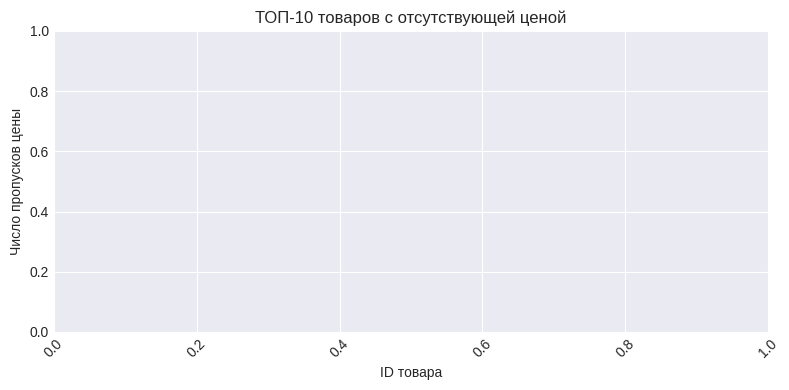



Данные о календаре (calendar) — пропуски по событиям:
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
dtype: int64

Число дней с событием 1: 162
Число дней с событием 2: 5


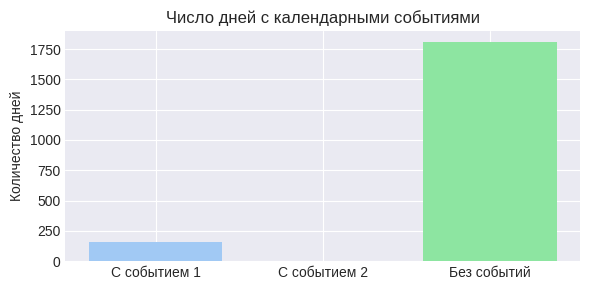

In [21]:
print("=== АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===")

# Пропуски в данных о продажах
print("\nДанные о продажах (sales_train) — количество пропусков по столбцам:")
print(sales_train.isnull().sum())

# Пропущенные цены
print("\n\nДанные о ценах (prices) — анализ пропусков:")
missing_prices = prices[prices['sell_price'].isnull()]
print(f"Всего строк с отсутствующей ценой: {len(missing_prices)}")
print(f"\nУникальных товаров с пропущенной ценой: {missing_prices['item_id'].nunique()}")
print(f"\nПримеры строк с пропущенной ценой:")
print(missing_prices.head(10))

# Отрисовка! Барплот количества пропусков по item_id с отсутствующей ценой (топ-10)
plt.figure(figsize=(8, 4))
top_missing = missing_prices['item_id'].value_counts().head(10)
sns.barplot(x=top_missing.index, y=top_missing.values, palette="flare")
plt.title("ТОП-10 товаров с отсутствующей ценой")
plt.xlabel("ID товара")
plt.ylabel("Число пропусков цены")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Пропуски в календарных событиях
print("\n\nДанные о календаре (calendar) — пропуски по событиям:")
event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
print(calendar[event_cols].isnull().sum())
print(f"\nЧисло дней с событием 1: {calendar['event_name_1'].notna().sum()}")
print(f"Число дней с событием 2: {calendar['event_name_2'].notna().sum()}")

# Отрисовка: доля дней с событиями
plt.figure(figsize=(6,3))
event_counts = [
    calendar['event_name_1'].notna().sum(),
    calendar['event_name_2'].notna().sum(),
    calendar.shape[0] - (calendar['event_name_1'].notna() | calendar['event_name_2'].notna()).sum(),
]
labels = ['С событием 1', 'С событием 2', 'Без событий']
colors = sns.color_palette("pastel")[0:3]
plt.bar(labels, event_counts, color=colors)
plt.title("Число дней с календарными событиями")
plt.ylabel("Количество дней")
plt.tight_layout()
plt.show()


- В календаре пропуски в `event_name_1/2` и `event_type_1/2` соответствуют дням **без событий**: заполнены только 162 дня с событием 1 и 5 дней с событием 2, а остальные строки можно трактовать как «нет события».
- В данных о продажах (`sales_train`) отсутствуют пропуски по всем столбцам; нули в продажах отражают реальные дни без спроса, а не потерю данных.  
- В таблице цен (`prices`) нет ни одной строки и ни одного товара с отсутствующей `sell_price`, поэтому ценовой признак полностью наблюдаем и не требует дополнительного восстановления.


### 3.5 Feature Importance (Correlation with Target)

In [22]:
print("=== ВАЖНОСТЬ ПРИЗНАКОВ: СВЯЗЬ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")

# Кодирование категориальных переменных для корреляционного анализа
sales_encoded = sales_long.copy()

# Кодируем категориальные признаки
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feat in categorical_features:
    sales_encoded[f'{feat}_encoded'] = le.fit_transform(sales_encoded[feat])

# Извлекаем временные признаки
sales_encoded['day_of_week'] = sales_encoded['date'].dt.dayofweek
sales_encoded['month'] = sales_encoded['date'].dt.month
sales_encoded['quarter'] = sales_encoded['date'].dt.quarter
sales_encoded['day_of_month'] = sales_encoded['date'].dt.day
sales_encoded['week_of_year'] = sales_encoded['date'].dt.isocalendar().week

# Вычисляем корреляции с продажами
correlation_features = [f'{feat}_encoded' for feat in categorical_features] + \
                       ['day_of_week', 'month', 'quarter', 'day_of_month', 'week_of_year']

correlations = sales_encoded[[f for f in correlation_features if f in sales_encoded.columns] + ['sales']].corr()['sales'].drop('sales')
correlations = correlations.abs().sort_values(ascending=False)

print("\nАбсолютные значения корреляций с продажами (ТОП признаков):")
print(correlations.head(10))

=== ВАЖНОСТЬ ПРИЗНАКОВ: СВЯЗЬ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===

Абсолютные значения корреляций с продажами (ТОП признаков):
cat_id_encoded      0.110426
dept_id_encoded     0.095179
item_id_encoded     0.090728
day_of_week         0.031249
store_id_encoded    0.021474
state_id_encoded    0.021035
day_of_month        0.015400
week_of_year        0.001986
month               0.000728
quarter             0.000674
Name: sales, dtype: float64


### 3.6 Graphical Visualization of Features

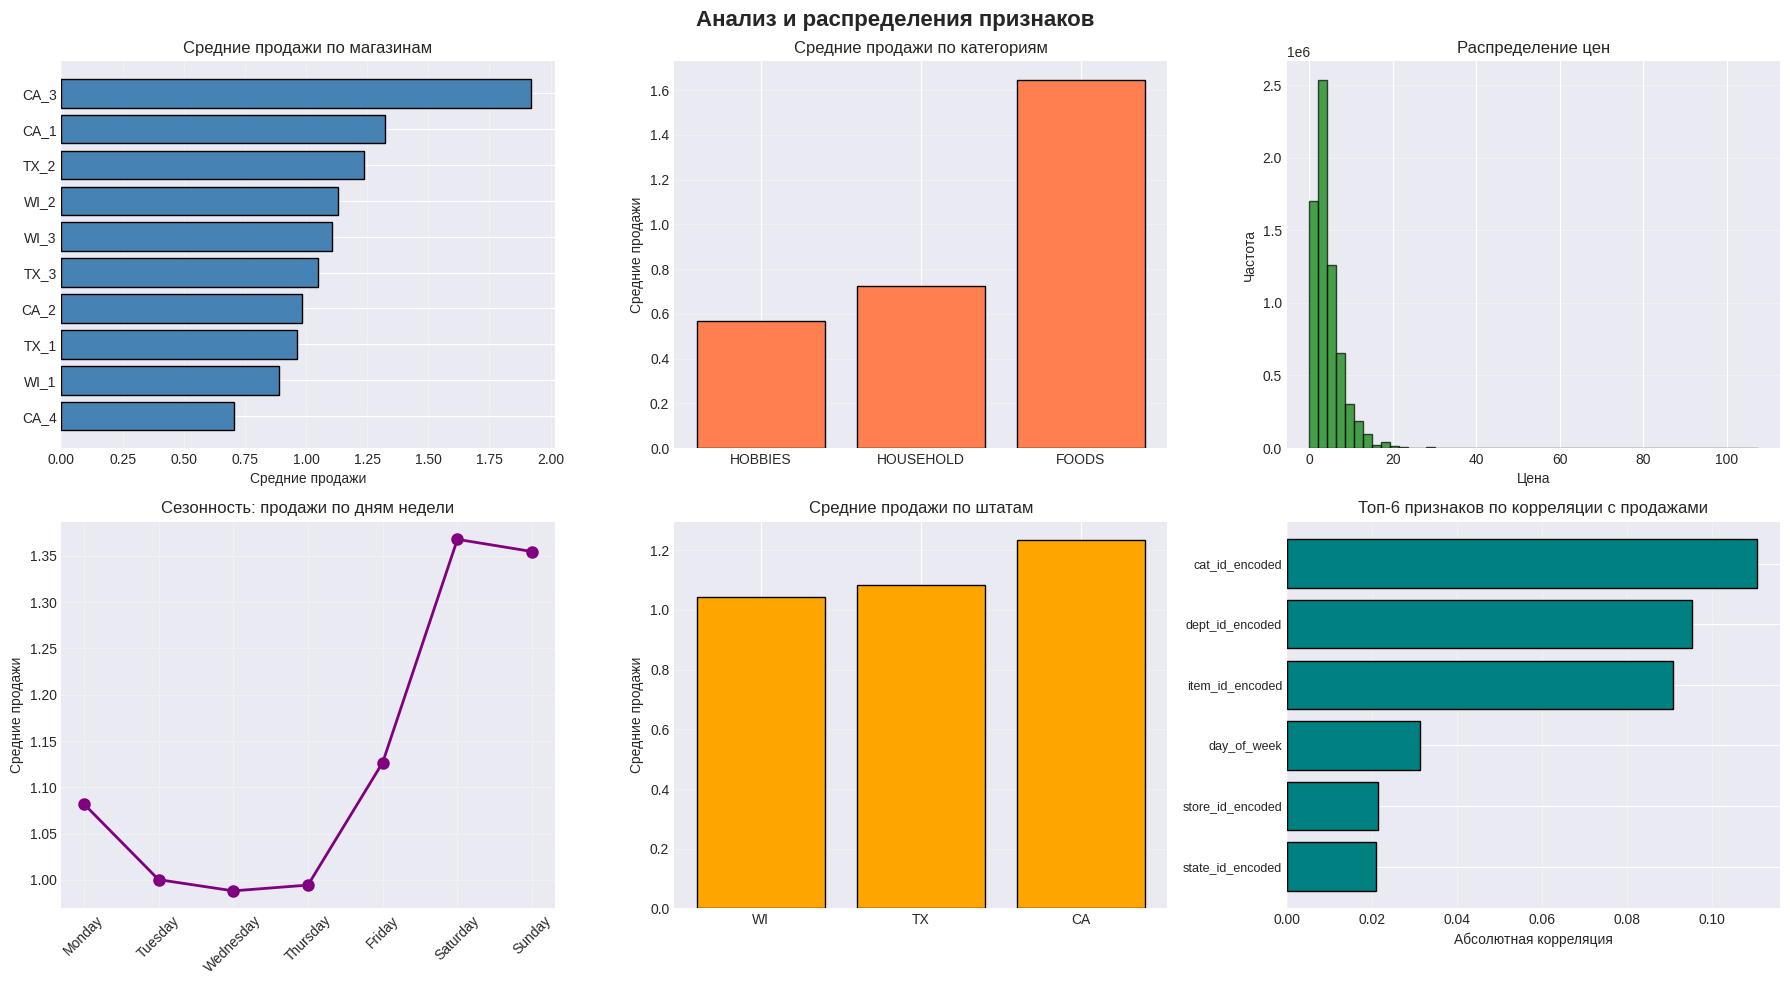

✓ Визуализация признаков завершена


In [24]:
# Визуализация признаков
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Анализ и распределения признаков', fontsize=16, fontweight='bold')

# 1. Средние продажи по магазинам
store_sales_mean = sales_long.groupby('store_id')['sales'].mean().sort_values()
axes[0, 0].barh(store_sales_mean.index.astype(str), store_sales_mean.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Средние продажи')
axes[0, 0].set_title('Средние продажи по магазинам')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Средние продажи по категориям
cat_sales_mean = sales_long.groupby('cat_id')['sales'].mean().sort_values()
axes[0, 1].bar(cat_sales_mean.index.astype(str), cat_sales_mean.values, color='coral', edgecolor='black')
axes[0, 1].set_ylabel('Средние продажи')
axes[0, 1].set_title('Средние продажи по категориям')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Распределение цен
axes[0, 2].hist(prices['sell_price'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Цена')
axes[0, 2].set_ylabel('Частота')
axes[0, 2].set_title('Распределение цен')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Продажи по дням недели
dow_sales = sales_long.groupby('dow')['sales'].mean().reindex(dow_order)
axes[1, 0].plot(dow_order, dow_sales.values, marker='o', color='purple', linewidth=2, markersize=8)
axes[1, 0].set_ylabel('Средние продажи')
axes[1, 0].set_title('Сезонность: продажи по дням недели')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Средние продажи по штатам
state_sales_mean = sales_long.groupby('state_id')['sales'].mean().sort_values()
axes[1, 1].bar(state_sales_mean.index.astype(str), state_sales_mean.values, color='orange', edgecolor='black')
axes[1, 1].set_ylabel('Средние продажи')
axes[1, 1].set_title('Средние продажи по штатам')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Топ-6 признаков по корреляции с продажами
top_corr = correlations.head(6).sort_values()
axes[1, 2].barh(range(len(top_corr)), top_corr.values, color='teal', edgecolor='black')
axes[1, 2].set_yticks(range(len(top_corr)))
axes[1, 2].set_yticklabels(top_corr.index, fontsize=9)
axes[1, 2].set_xlabel('Абсолютная корреляция')
axes[1, 2].set_title('Топ-6 признаков по корреляции с продажами')
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✓ Визуализация признаков завершена")

- Наибольшую связь с целевой переменной показывают иерархические категориальные признаки: категория (`cat_id_encoded`), отдел (`dept_id_encoded`) и конкретный товар (`item_id_encoded`). 
- Из временных признаков особенно важен `day_of_week`, что отражает выраженную недельную сезонность спроса. 
- Признаки магазина и штата (`store_id_encoded`, `state_id_encoded`) дают умеренный вклад, тогда как месяц, квартал и номер недели года почти не коррелируют с продажами.

## Итоговые выводы и стратегия моделирования

### 1. Анализ целевой переменной (Target Variable)
- **Природа спроса:** Выявлен классический **прерывистый спрос (intermittent demand)**. Распределение сильно скошено вправо с огромным количеством нулей и «тяжелым хвостом».
- **Выбросы:** 99% продаж ≤ 15 единиц. Значения выше этого порога (0.94% выборки) являются экстремальными выбросами, которые могут дестабилизировать линейные модели, но важны для ритейла.
- **Сезонность:** Доминирует **недельная сезонность** (продажи в выходные значительно выше). Годовая сезонность выражена слабее, но присутствует на уровне категорий.

### 2. Структура и качество данных
- **Иерархия:** Категориальные признаки (`cat_id`, `dept_id`, `item_id`) имеют самую сильную корреляцию с целевой переменной. Иерархическая структура (Товар → Отдел → Категория) является ключевым источником сигнала.
- **Цены:** Данные о ценах (`sell_price`) **не имеют пропусков** (в отличие от первоначальных гипотез). Однако присутствуют товары с высокой волатильностью цены (CV > 0.3), указывающей на агрессивные промо-акции.
- **Календарь:** Событийные признаки (праздники) разрежены, но локально сильно влияют на продажи.

### 3. Стратегия Feature Engineering (Возможности для улучшения)

На основе EDA определены приоритетные направления для генерации признаков:

**А. Временные лаги и скользящие окна (Time Series Features)**
Это критически важно для захвата автокорреляции и трендов:
- **Лаги (Lags):** `sales_lag_7` (недельная сезонность), `sales_lag_28` (месячный цикл), `sales_lag_365` (годовая сезонность).
- **Скользящие статистики (Rolling):** Окна 7 и 28 дней для `mean` (тренд) и `std` (волатильность). Пример: `rolling_mean_7`, `rolling_std_14`.

**Б. Ценовые признаки (Price Features)**
Так как цена — экзогенный фактор, влияющий на спрос:
- **Относительная цена:** Отношение текущей цены к средней исторической или к цене конкурентов.
- **Price Momentum:** Изменение цены по сравнению с прошлой неделей (`price_current / price_lag_7`).
- **Эластичность:** Взаимодействие цены и категорий.

**В. Календарные и событийные признаки**
- **Расстояние до праздника:** `days_to_holiday` (эффект предпраздничных закупок).
- **Флаги выходных:** `is_weekend` (критично для захвата недельного паттерна).
- **Циклические признаки:** Кодирование дня недели и месяца через Sin/Cos.

**Г. Иерархическое кодирование (Target Encoding)**
- Средние продажи на разных уровнях иерархии: `item_store_avg`, `item_category_avg`, `store_state_avg`. Это поможет модели понять "базовый уровень" продаж для группы.

### 4. Рекомендации для моделирования
1.  **Предобработка:** Обязательное логарифмирование целевой переменной (`log1p`) для стабилизации дисперсии и уменьшения влияния выбросов.
2.  **Модели:** Градиентный бустинг (LightGBM/XGBoost/CatBoost) как основной алгоритм, способный обрабатывать пропуски и нелинейные зависимости.
3.  **Валидация:** Использовать TimeSeriesSplit (валидация на последних 28 днях), чтобы избежать заглядывания в будущее.
